In [1]:
import imgaug as ia
import cv2 as cv
import numpy as np
import os
import shutil
from imgaug import augmenters as iaa
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
# 例としてビーバーの画像を使用
image = ia.quokka(size=(256, 256))

# バウンディングボックスを定義
bb = ia.BoundingBoxesOnImage([
    ia.BoundingBox(x1=55, y1=50, x2=110, y2=150,label="a"),ia.BoundingBox(x1=70, y1=100, x2=600, y2=200),
], shape=image.shape)

In [3]:
aug1 = iaa.Dropout(p=0.2)
aug2 = iaa.AverageBlur(k=(5, 20))
aug3 =  iaa.Add((-40, 40), per_channel=0.5)
aug4 = iaa.ContrastNormalization((0.5, 1.5), per_channel=0.5)
aug5 = iaa.Affine(rotate=(0,20))

In [4]:
def augment_pic( img , aug ):# 画像に変換を適用する
    aug_img = aug.augment_image(img)
 
    # 描画
    plt.subplot(121).imshow(img)
    plt.subplot(122).imshow(aug_img)
    plt.show()

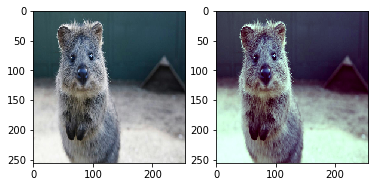

In [5]:
augment_pic(image ,aug4)

(1836, 3264, 3)


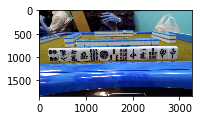

In [6]:
a = cv.imread('E:/test/0.jpg')
print(a.shape)
fig = plt.figure()
fig.add_subplot(121).imshow(a)
plt.show()

In [7]:
def augment( img , bb , aug ):
    # 画像とバウンディングボックスを変換
    aug_img = aug.augment_image( img ) 
    aug_bb = aug.augment_bounding_boxes([bb])[0].remove_out_of_image().cut_out_of_image()
    
    # バウンディングボックスと画像を重ねる
    image_before = bb.draw_on_image(img, thickness=2, color=[255, 0,0])
    image_after = aug_bb.draw_on_image(aug_img, thickness=2, color=[0, 255, 0])

    '''
    # 変換前後の画像を描画
    fig = plt.figure()
    fig.add_subplot(121).imshow(image_before)
    fig.add_subplot(122).imshow(image_after)
    plt.show()
    '''
    
    return aug_img , aug_bb

In [8]:
aug_img , aug_bb = augment(image , bb ,aug5)
print(aug_bb)

BoundingBoxesOnImage([BoundingBox(x1=51.5890, y1=31.8976, x2=133.9220, y2=143.7533, label=a), BoundingBox(x1=50.9865, y1=84.0956, x2=256.0000, y2=256.0000, label=None)], shape=(256, 256, 3))


xmlからバウンディングボックスを取る。もしかするともっと良い関数があるかもしれない。

In [9]:
def From_xml(filename):
    tree = ET.parse( filename )
    x1 = []
    x2 = []
    y1 = []
    y2 = []
    label = []
    boxes = []
    
    xmins = tree.findall('object/bndbox/xmin')
    for xmin in xmins:
        x1.append(xmin.text)
    xmaxs = tree.findall('object/bndbox/xmax')
    for xmax in xmaxs:
        x2.append(xmax.text)
    ymins = tree.findall('object/bndbox/ymin')
    for ymin in ymins:
        y1.append(ymin.text)
    ymaxs = tree.findall('object/bndbox/ymax')
    for ymax in ymaxs:
        y2.append(ymax.text)
    names = tree.findall('object/name')
    for name in names:
        label.append(name.text)
    width = tree.findall('size/width')[0].text
    height = tree.findall('size/height')[0].text    
        
    for i in range(len(x1)):
        boxes.append(ia.BoundingBox(x1=float(x1[i]), y1=float(y1[i]), x2=float(x2[i]), y2=float(y2[i]),label=label[i]))
    
    # バウンディングボックスを定義
    bb = ia.BoundingBoxesOnImage( boxes , shape=(int(width),int(height),3))
    
    return bb

In [10]:
print(From_xml("2018_test.xml"))

BoundingBoxesOnImage([BoundingBox(x1=186.0000, y1=840.0000, x2=424.0000, y2=1119.0000, label=4p), BoundingBox(x1=424.0000, y1=830.0000, x2=642.0000, y2=1106.0000, label=8m), BoundingBox(x1=214.0000, y1=857.0000, x2=462.0000, y2=1144.0000, label=8m), BoundingBox(x1=631.0000, y1=847.0000, x2=852.0000, y2=1109.0000, label=6m), BoundingBox(x1=849.0000, y1=854.0000, x2=1069.0000, y2=1106.0000, label=hatsu), BoundingBox(x1=1069.0000, y1=837.0000, x2=1293.0000, y2=1092.0000, label=9s), BoundingBox(x1=1300.0000, y1=864.0000, x2=1493.0000, y2=1109.0000, label=1p), BoundingBox(x1=1500.0000, y1=830.0000, x2=1707.0000, y2=1085.0000, label=3s), BoundingBox(x1=1707.0000, y1=823.0000, x2=1907.0000, y2=1088.0000, label=9s), BoundingBox(x1=1914.0000, y1=816.0000, x2=2114.0000, y2=1085.0000, label=tyun), BoundingBox(x1=2114.0000, y1=816.0000, x2=2335.0000, y2=1075.0000, label=1m), BoundingBox(x1=2331.0000, y1=816.0000, x2=2531.0000, y2=1082.0000, label=7s), BoundingBox(x1=2538.0000, y1=809.0000, x2=2749

バウンディングボックスからxmlを作る。save_dirは最後に／が必要なので注意

In [11]:
#XMLファイルの生成
def To_Xml( filename , bb , save_dir = ""):
        Annotation = ET.Element('annotation')
        Filename = ET.SubElement(Annotation,'filename')
        Filename.text = filename +'.jpg'

        size = ET.SubElement(Annotation,'size')
        width = ET.SubElement(size,'width')
        width.text = str(bb.shape[0])
        height = ET.SubElement(size,'height')
        height.text = str(bb.shape[1])

        for i in range(len(bb.bounding_boxes)):
            Object = ET.SubElement(Annotation, 'object')
            name = ET.SubElement(Object, 'name')
            name.text = str(bb.bounding_boxes[i].label)
            bndbox = ET.SubElement(Object, 'bndbox')
            xmin = ET.SubElement(bndbox, 'xmin')
            xmin.text = str(bb.bounding_boxes[i].x1)
            ymin = ET.SubElement(bndbox, 'ymin')
            ymin.text = str(bb.bounding_boxes[i].y1)
            xmax = ET.SubElement(bndbox, 'xmax')
            xmax.text = str(bb.bounding_boxes[i].x2)
            ymax = ET.SubElement(bndbox, 'ymax')
            ymax.text = str(bb.bounding_boxes[i].y2)
    
        tree = ET.ElementTree(element=Annotation)
        
        #保存
        filename = save_dir + filename + '.xml'
        tree.write(filename, encoding='utf-8', xml_declaration=True)

ファイルを連番にする

In [12]:
file_path = 'E:/デスクトップ/majung_zoo'
save_path = 'E:/デスクトップ/test'
def renban(file_path , save_path):
    files = os.listdir(path = file_path)
    print(len(files))
    for i in range(int(len(files)/2)):
        print(files[2*i])

        shutil.copyfile(file_path+'/'+files[2*i] ,save_path+'/'+str(i)+'.jpg')
        bb = From_xml(file_path+'/'+files[2*i+1])
        To_Xml( str(i) , bb , save_dir = save_path+"/")

アノテーションデータを水増しする

In [13]:
#XMLファイルの生成
def To_Resized_Xml( filename , bb , pic_size, save_dir = ""):
        Annotation = ET.Element('annotation')
        Filename = ET.SubElement(Annotation,'filename')
        Filename.text = filename +'.jpg'

        size = ET.SubElement(Annotation,'size')
        width = ET.SubElement(size,'width')
        width.text = str(pic_size)
        height = ET.SubElement(size,'height')
        height.text = str(pic_size)

        bai = pic_size/bb.shape[0]
        
        for i in range(len(bb.bounding_boxes)):
            Object = ET.SubElement(Annotation, 'object')
            name = ET.SubElement(Object, 'name')
            name.text = str(bb.bounding_boxes[i].label)
            bndbox = ET.SubElement(Object, 'bndbox')
            xmin = ET.SubElement(bndbox, 'xmin')
            xmin.text = str(int(bai* bb.bounding_boxes[i].x1))
            ymin = ET.SubElement(bndbox, 'ymin')
            ymin.text = str(int(bai* bb.bounding_boxes[i].y1))
            xmax = ET.SubElement(bndbox, 'xmax')
            xmax.text = str(int(bai* bb.bounding_boxes[i].x2))
            ymax = ET.SubElement(bndbox, 'ymax')
            ymax.text = str(int(bai* bb.bounding_boxes[i].y2))
    
        tree = ET.ElementTree(element=Annotation)
        
        #保存
        filename = save_dir + filename + '.xml'
        tree.write(filename, encoding='utf-8', xml_declaration=True)
        
def Resize( size ,img ):
    #サイズは横のほうが大きいと決めつけ
    height, width = img.shape[:2]
    bai = size/width
    h = int(height*bai)
    w = size
    img2 = cv.resize(img,( w,h ))
    img_re = np.ones(( size, size, 3),np.uint8)
    img_re[0:h, 0:w] = img2
    
    return img_re

In [14]:
def main(file_path , save_path , modes , size):
    files = os.listdir(path = file_path)
    num = int(len(files)/2)
    print("file num is" + str(num))

    for i in range(num):
        print(file_path + files[2*i])
    
        img = cv.imread(file_path + files[2*i])
        bb = From_xml(file_path + files[2*i+1])
    
        for j in range(len(modes)):
            aug_img , aug_bb = augment(img , bb ,modes[j])
            
            resized_img = Resize( size , aug_img )
            
            cv.imwrite(save_path +str(i + num * (j+1) )+".jpg", resized_img)
            To_Resized_Xml( str(i + num * (j+1)) , aug_bb , size ,save_dir = save_path)

In [16]:
main('E:/new/1/','E:/new/train/',[aug1,aug2,aug3,aug4,aug5],512)

file num is84
E:/new/1/0.jpg
E:/new/1/1.jpg
E:/new/1/10.jpg
E:/new/1/11.jpg
E:/new/1/12.jpg
E:/new/1/13.jpg
E:/new/1/14.jpg
E:/new/1/15.jpg
E:/new/1/16.jpg


KeyboardInterrupt: 

In [26]:
def test(file_path , save_path , size):
    files = os.listdir(path = file_path)
    num = int(len(files)/2)
    print("file num is" + str(num))

    for i in range(num):
        print(file_path + files[2*i])
    
        img = cv.imread(file_path + files[2*i])
        bb = From_xml(file_path + files[2*i+1])
        
        resized_img = Resize( size , img )
        
        cv.imwrite(save_path +str(i)+".jpg", resized_img)
        To_Resized_Xml( str(i) , bb , size ,save_dir = save_path)
        
#test('E:/test/','E:/normal/',512)